In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import torch
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
l = 0.01

def pde(x, y):
        u = y[:, 0:1]
        k = y[:, 1:2]
        du_xx = dde.grad.hessian(y, x, component=0)
        return l * du_xx - k * u - torch.sin(2 * np.pi * x)

In [3]:
def k(x):
        return 0.1 + np.exp(-0.5 * (x - 0.5) ** 2 / 0.15 ** 2)

In [4]:
def fun(x, y):
        return np.vstack((y[1], 100 * (k(x) * y[0] + np.sin(2 * np.pi * x))))

In [5]:
def bc(ya, yb):
    return np.array([ya[0], yb[0]])

In [6]:
a = np.linspace(0, 1, 1000)
b = np.zeros((2, a.size))

res = solve_bvp(fun, bc, a, b)

def sol(x):
    return res.sol(x)[0]

def du(x):
    return res.sol(x)[1]

Compiling model...
'compile' took 2.284455 s

Training model...

Step      Train loss                        Test loss                         Test metric             
0         [4.66e-01, 2.16e-02, 8.18e-01]    [4.98e-01, 2.16e-02, 8.18e-01]    [1.06e+00, 1.03e+00]    
1000      [1.98e-01, 7.45e-02, 5.63e-01]    [1.60e-01, 7.45e-02, 5.63e-01]    [8.60e-01, 4.91e+00]    
2000      [1.09e-02, 1.02e-02, 7.22e-02]    [1.55e-02, 1.02e-02, 7.22e-02]    [3.06e-01, 8.01e-01]    
3000      [1.49e-03, 1.97e-04, 7.39e-03]    [3.66e-03, 1.97e-04, 7.39e-03]    [9.98e-02, 6.73e-01]    
4000      [5.85e-04, 2.32e-05, 1.59e-03]    [1.04e-03, 2.32e-05, 1.59e-03]    [4.76e-02, 4.13e-01]    
5000      [2.77e-04, 1.26e-06, 2.64e-04]    [4.75e-04, 1.26e-06, 2.64e-04]    [2.27e-02, 3.04e-01]    
6000      [1.51e-04, 8.56e-08, 1.37e-04]    [2.76e-04, 8.56e-08, 1.37e-04]    [1.78e-02, 2.72e-01]    
7000      [8.30e-05, 2.78e-08, 1.16e-04]    [1.90e-04, 2.78e-08, 1.16e-04]    [1.61e-02, 2.48e-01]    
8000    

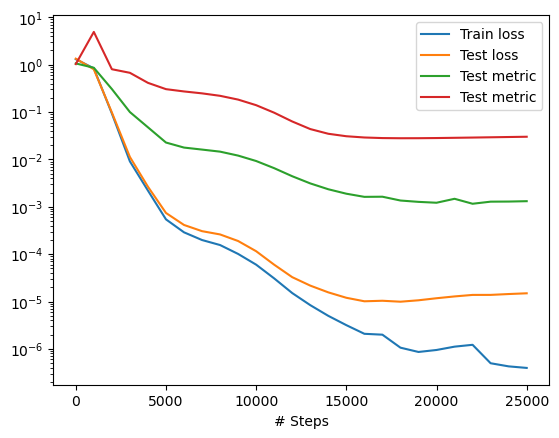

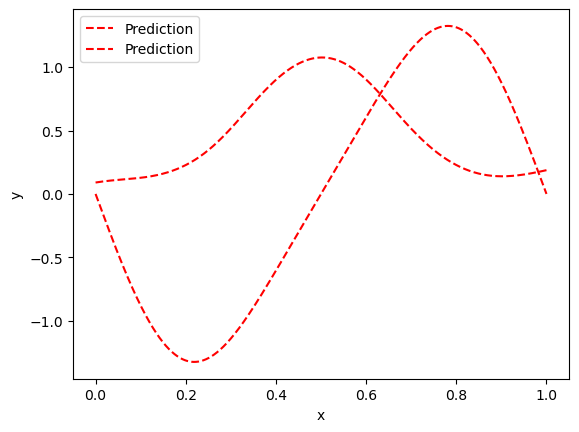

In [7]:
def gen_traindata(num):
    xvals = np.linspace(0, 1, num)
    yvals = sol(xvals)

    return np.reshape(xvals, (-1, 1)), np.reshape(yvals, (-1, 1))

geom = dde.geometry.Interval(0, 1)

ob_x, ob_u = gen_traindata(8)
observe_u = dde.PointSetBC(ob_x, ob_u, component=0)
bc = dde.DirichletBC(geom, sol, lambda _, on_boundary: on_boundary, component=0)

data = dde.data.PDE(geom, 
                    pde, 
                    bcs=[bc, observe_u], 
                    num_domain=40, 
                    num_boundary=2,
                    train_distribution="pseudo", 
                    num_test=1000)

layer_size = [1] + [32] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

xx = np.linspace(0, 1, 1001)[:, None]

def l2_u(_, __):
    return dde.metrics.l2_relative_error(sol(xx), model.predict(xx)[:, 0:1])

def l2_k(_, __):
    return dde.metrics.l2_relative_error(k(xx), model.predict(xx)[:, 1:2])


model.compile("adam", lr=0.0001, metrics=[l2_u, l2_k])
losshistory, train_state = model.train(epochs=25000, model_save_path = "diff_react")

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

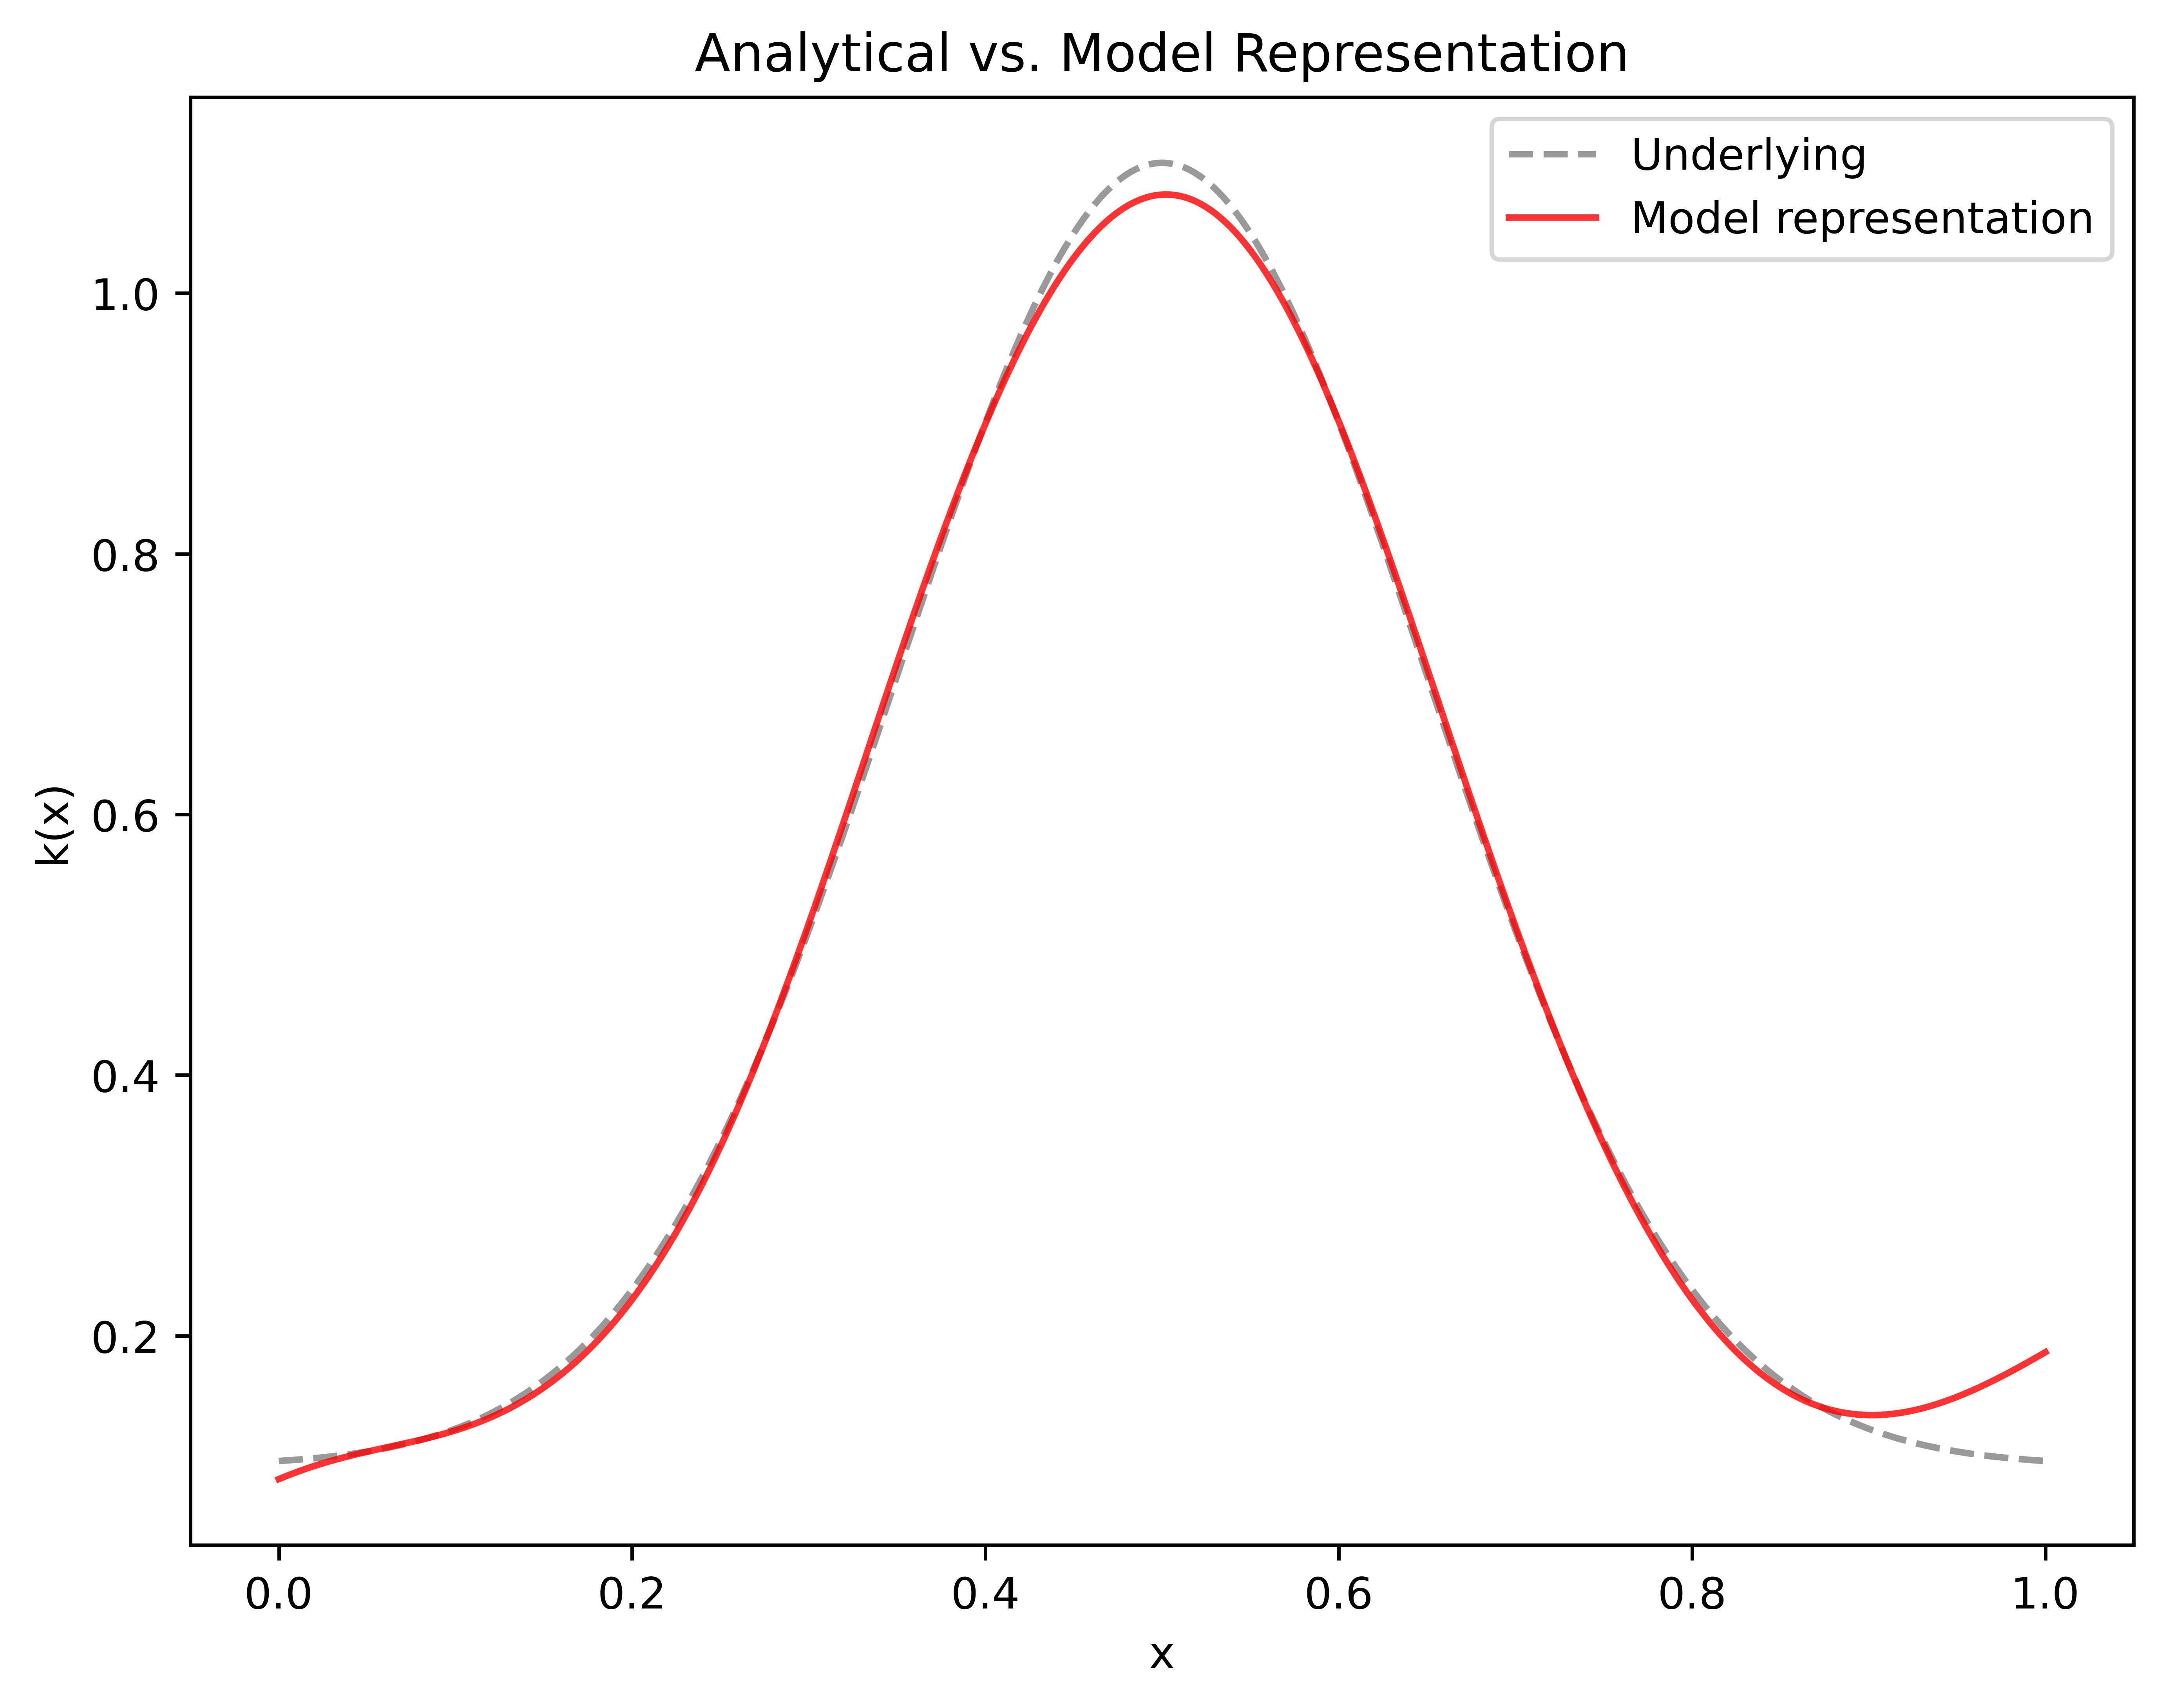

In [8]:
x = np.linspace(0, 1, 1000)
x_reshaped = x.reshape((len(x), 1))
plt.figure(figsize=(8,6), dpi = 800)
plt.plot(x, k(x), linestyle = "--", label = "Underlying", color = "grey", alpha = 0.8)
plt.plot(x, model.predict(x_reshaped)[:, 1:], linestyle = "-", label = "Model representation", color = "r", alpha = 0.8)
plt.xlabel("x")
plt.ylabel("k(x)")
plt.title("Analytical vs. Model Representation")
plt.legend()